In [1]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

import kornia as K
import kornia.metrics as metrics
from torchvision import datasets
import random

# We will use atomai just to create the dataset
import atomai as aoi
from scipy import ndimage
import cv2 as cv
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import pyroved as pv
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition, mixture
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.spatial.distance import cdist

tt = torch.tensor

/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_1135/1849301169.py:22: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter
/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_1135/1849301169.py:23: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_1135/1849301169.py:23: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

In [2]:
def get_coordinates(image):
    threshData = cv.adaptiveThreshold(image, 110, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv.THRESH_BINARY,25,-29)
    contours, hierarchy = cv.findContours(threshData, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)

    coordinates = []
    match_shapes = []
    circle_mask = np.zeros(image.shape)
    circle = cv.circle(circle_mask,(150,150),3,255,2)
    
    for i, count in enumerate(contours):
    
        area = cv.contourArea(count)
        x,y,w,h = cv.boundingRect(count)
        rect_area = w*h
        extent = float(area)/rect_area
        ret = cv.matchShapes(circle,count,1,0.0)
        match_shapes.append(ret)
    
        if extent<0.19:
            match_shapes[i] = 0
        
        if extent > 0.19:  #Filters out edges
            mask = np.zeros(image.shape)
            cv.drawContours(mask, [count], -1, (0, 255, 0), 1)
            kpCnt = len(count)
            x = 0
            y = 0
        
            for kp in count:
                x = x+kp[0][0]
                y = y+kp[0][1]
    
            coordinates.append(np.array([i,x/kpCnt, y/kpCnt]))
    
    coordinates = np.stack(coordinates)
    match_shapes = np.asarray(match_shapes)
    
    for i, shape in enumerate(match_shapes):
        if shape > 1:
            coordinates = coordinates[coordinates[:,0] != i]
    
    coordinates = coordinates[:,1:]
    
    for i, count in enumerate(contours):
        if match_shapes[i] > 1:
            dimer_mask = np.zeros(image.shape)
            cv.drawContours(dimer_mask, [contours[i]], -1, 1, -1)
            region_of_interest = image * dimer_mask
            neighborhood = generate_binary_structure(2,2)
            local_max = maximum_filter(region_of_interest, footprint=neighborhood)==region_of_interest
            background = (region_of_interest==0)
            eroded_background = binary_erosion(background, structure = neighborhood, border_value =1)
            detected_peaks = local_max ^ eroded_background
            if np.where(detected_peaks == True)[0].shape[0] > 1:
                peak_coords_list = []
                for j in range(np.where(detected_peaks == True)[0].shape[0]):
                    peak_coords = np.array([[np.where(detected_peaks == True)[1][j],
                                             np.where(detected_peaks == True)[0][j]]])
                    peak_coords_list.append(peak_coords)
    
                peak_coords_list = np.asarray(peak_coords_list).reshape(np.where(detected_peaks == True)[0].shape[0],2)
    
                distances = cdist(peak_coords_list, peak_coords_list)
                close_peaks = np.where((distances <= 4) & (distances != 0))
                faulty_peaks = np.where((distances <= 1) & (distances != 0))
                
                peaks_to_remove = set()
    
                if peak_coords_list.shape[0] > 2:
                    for i, j in zip(close_peaks[0], close_peaks[1]):
                        if i < j:  
                            peaks_to_remove.add(j)
                
                else:
                    for i,j in zip(faulty_peaks[0], faulty_peaks[1]):
                        if i < j:
                            peaks_to_remove.add(j)
    
                peak_coords_list = np.delete(peak_coords_list, list(peaks_to_remove), axis=0)
    
                coordinates = np.concatenate((coordinates, peak_coords_list), axis=0)
            else:
                single_peak_coords = np.array([np.where(detected_peaks == True)[1],
                                             np.where(detected_peaks == True)[0]]).reshape(1,2)
                coordinates = np.concatenate((coordinates, single_peak_coords), axis=0)
    
    return(coordinates)

In [8]:
from sklearn.model_selection import train_test_split

images = np.load('cropped_training_data_B0376.npy')
coordinates = np.load('training_coordinates_B0376.npy')
coordinates[:,[1,0]] = coordinates[:,[0,1]]
expdata = np.load("validation_img_B0376.npy")
d0, d1, d2 = images.shape


GMM components


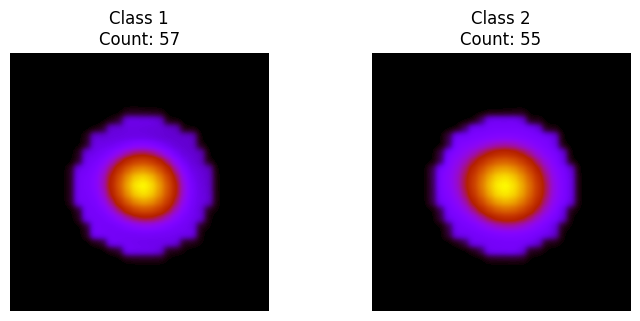

In [45]:
import matplotlib.gridspec as gridspec
window_size = 32
n_components = 2
covariance = 'diag'
random_state = 1
clf = mixture.GaussianMixture(
    n_components = n_components,
    covariance_type = covariance,
    random_state = random_state)
X_vec = images.reshape(d0,d1*d2)
classes = clf.fit_predict(X_vec) +1
cla = np.ndarray(shape=(
    np.amax(classes), int(window_size), int(window_size)))

rows = int(np.ceil(float(n_components)/5))
cols = int(np.ceil(float(np.amax(classes))/rows))
fig = plt.figure(figsize=(4*cols, 4*(1+rows//2)))
gs = gridspec.GridSpec(rows, cols)
print('\nGMM components')

cl_all = []
for i in range(np.amax(classes)):
    cl = images[classes == i + 1]
    cl_all.append(cl)
    cla[i] = np.mean(cl, axis=0)
    ax = fig.add_subplot(gs[i])
    ax.imshow(cla[i, :, :], cmap='gnuplot',
            interpolation='Gaussian')
    ax.axis('off')
    ax.set_title('Class '+str(i+1)+'\nCount: '+str(len(cl)))

plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()


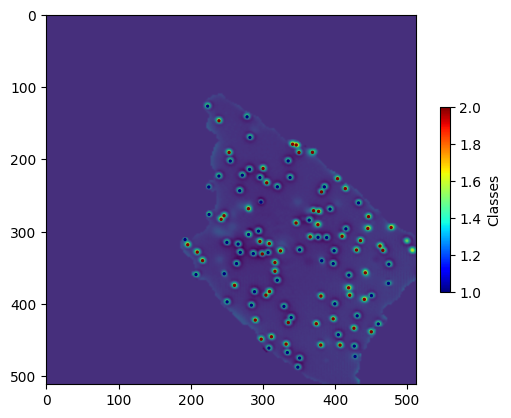

In [44]:
sc = plt.scatter(coordinates[:, 0], coordinates[:, 1], c=classes, s=2,
            cmap="jet")
im = plt.imshow(expdata)
plt.colorbar(sc, shrink=0.5, label="Classes")
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
images_train, images_test = train_test_split(
    images, test_size=0.2, shuffle=True, random_state=0)

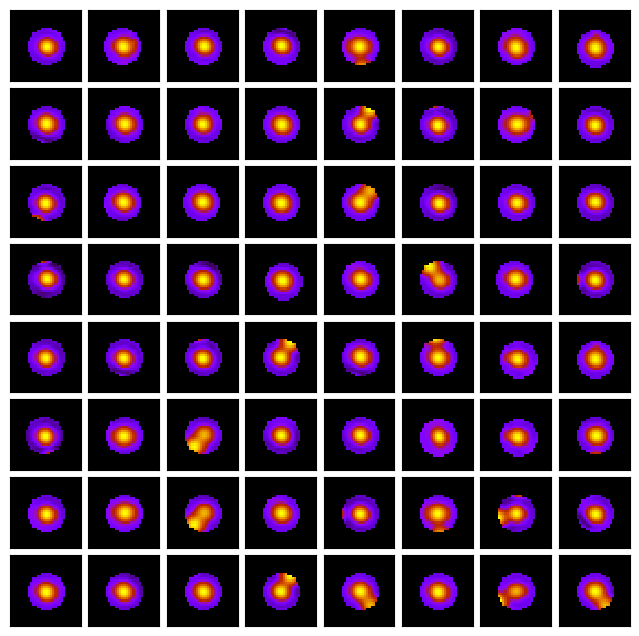

In [6]:
# Visulaizing the training dataset
np.random.seed(15)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(images))
    ax.imshow(images[i], cmap='gnuplot', interpolation='nearest')

In [8]:
# Training the rVAE on the subimages generated
in_dim = (window_size, window_size)   # Input dimensions of the dataset i.e., shape of each card's image

rvae_mgo = aoi.models.rVAE(in_dim)

rvae_mgo.fit(X_train=images_train, X_test=images_test, training_cycles=200, batch_size=5)

/opt/anaconda3/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/200, Training loss: 1039791.1654, Test loss: 1071567.1094
Epoch: 2/200, Training loss: 1035484.8676, Test loss: 1041847.5938
Epoch: 3/200, Training loss: 1020642.5147, Test loss: 1042833.8125
Epoch: 4/200, Training loss: 1000318.8272, Test loss: 1053626.4062
Epoch: 5/200, Training loss: 985470.9669, Test loss: 1030553.8438
Epoch: 6/200, Training loss: 974181.0000, Test loss: 990077.2656
Epoch: 7/200, Training loss: 964575.4301, Test loss: 990377.8125
Epoch: 8/200, Training loss: 953093.2574, Test loss: 990420.5469
Epoch: 9/200, Training loss: 941237.7941, Test loss: 951033.3750
Epoch: 10/200, Training loss: 930770.6581, Test loss: 1011907.5625
Epoch: 11/200, Training loss: 958684.3879, Test loss: 970547.5469
Epoch: 12/200, Training loss: 932359.7132, Test loss: 963429.5156
Epoch: 13/200, Training loss: 943432.4081, Test loss: 984386.4531
Epoch: 14/200, Training loss: 938126.8750, Test loss: 978356.6094
Epoch: 15/200, Training loss: 936883.2831, Test loss: 963887.6562
Epoch: 16

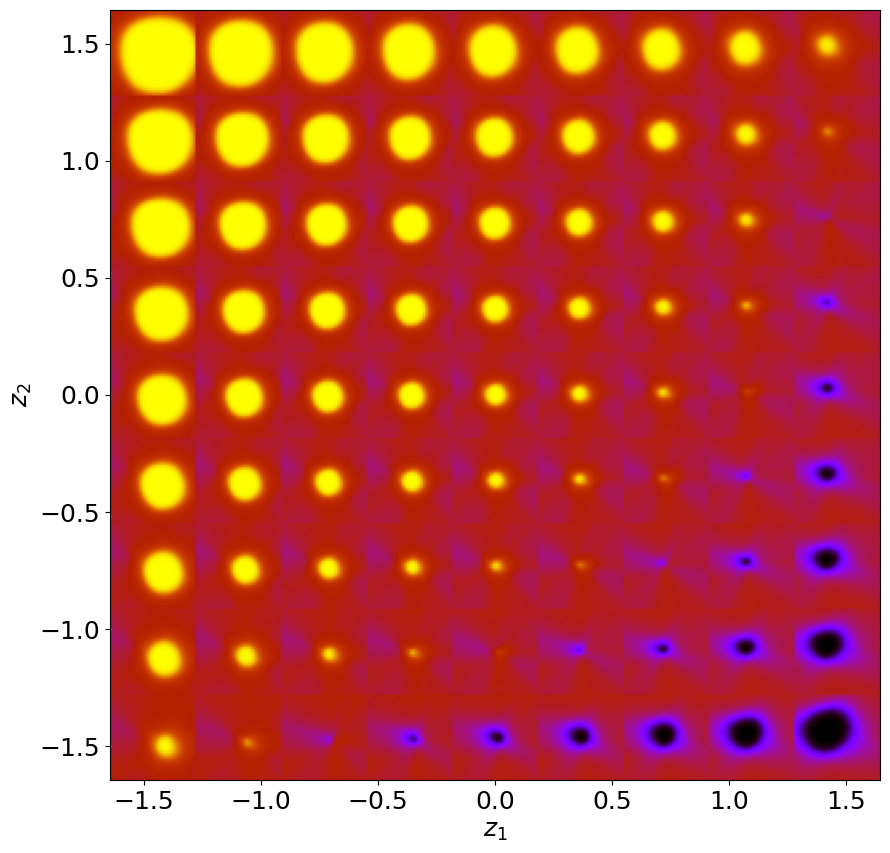

In [53]:
rvae_mgo.manifold2d(cmap="gnuplot");

In [11]:
z_mean, z_sd = rvae_mgo.encode(images)   # Encoding the full input dataset

#In case of rotational and translational invariance
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

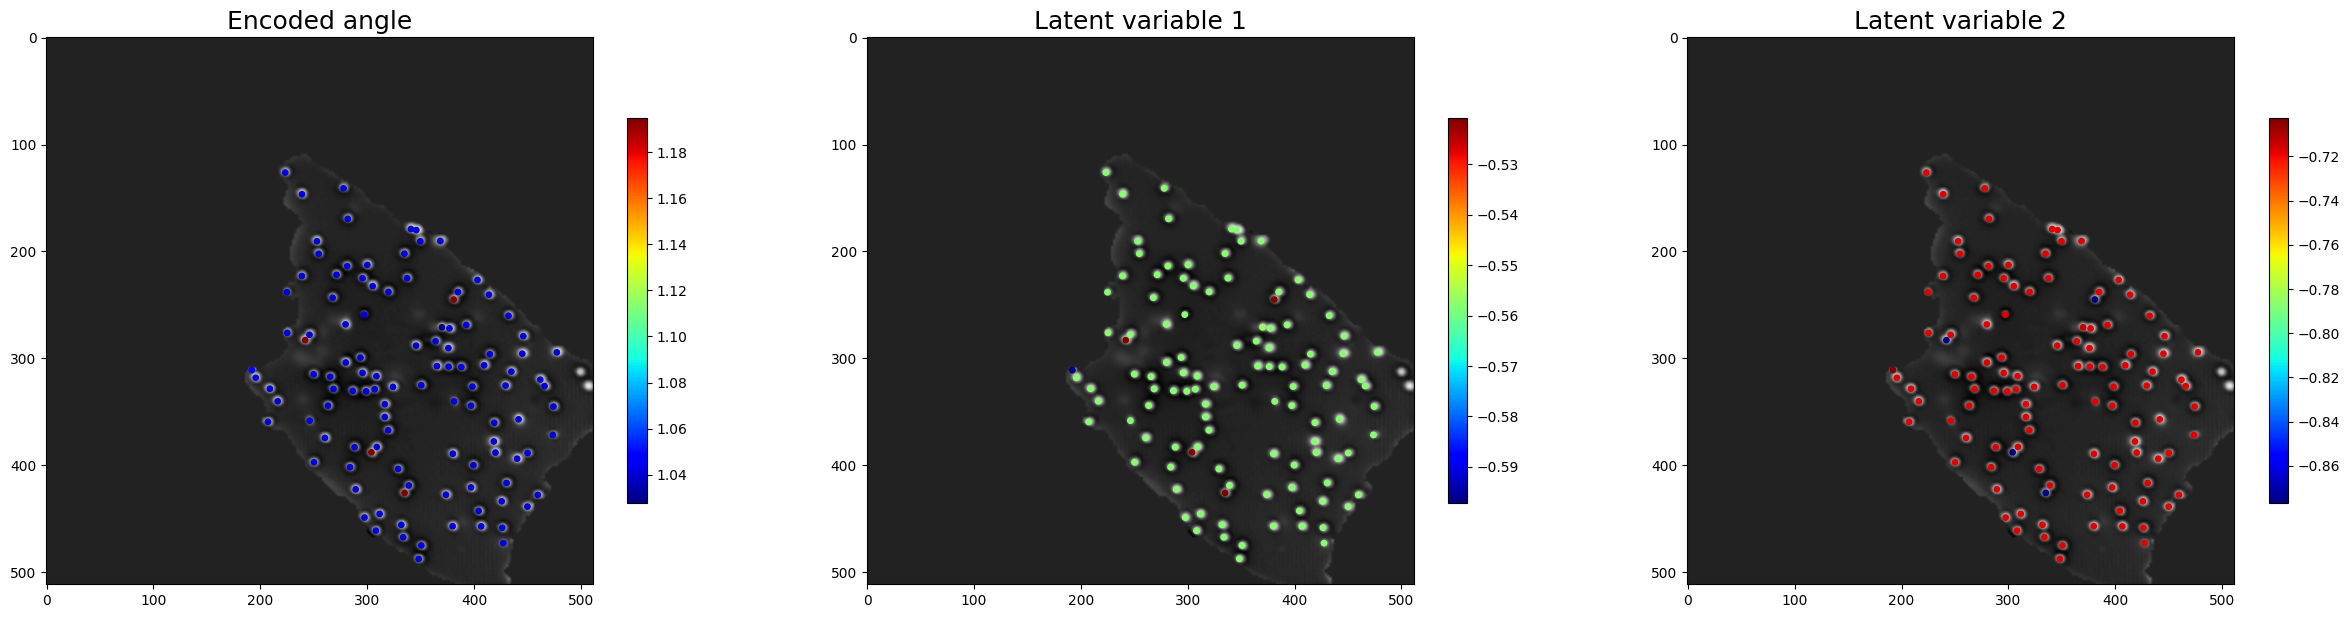

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(coordinates[:, 0], coordinates[:, 1], c=z1, s=15,
            cmap="jet")
ax[0].set_title("Encoded angle", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(coordinates[:, 0], coordinates[:, 1], c=z3[:,0], s=15,
            cmap="jet")
ax[1].set_title("Latent variable 1", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)

im2 = ax[2].imshow(expdata, cmap="gray")
sc2 = ax[2].scatter(coordinates[:, 0], coordinates[:, 1], c=z3[:,1], s=15,
              cmap="jet")
ax[2].set_title("Latent variable 2", fontsize=18)
fig.colorbar(sc2, ax=ax[2], shrink=.5)

plt.show()

In [27]:
#jvae
data_dim = (window_size, window_size)

jvae = aoi.models.jVAE(in_dim, latent_dim=2, discrete_dim=[5])

jvae.fit(X_train=images_train, X_test=images_test, training_cycles=200, batch_size=5)

Epoch: 1/200, Training loss: 1043225.6765, Test loss: 1066031.1719
Epoch: 2/200, Training loss: 1034024.6471, Test loss: 1110546.0938
Epoch: 3/200, Training loss: 1039356.8051, Test loss: 1079803.9219
Epoch: 4/200, Training loss: 1035700.3419, Test loss: 1061495.0781
Epoch: 5/200, Training loss: 1039078.0956, Test loss: 1069803.4531
Epoch: 6/200, Training loss: 1022842.5993, Test loss: 1092346.9375
Epoch: 7/200, Training loss: 1011196.4779, Test loss: 1073085.6719
Epoch: 8/200, Training loss: 1014455.1471, Test loss: 994855.7188
Epoch: 9/200, Training loss: 1000661.4081, Test loss: 1058367.6719
Epoch: 10/200, Training loss: 998752.7243, Test loss: 999928.4375
Epoch: 11/200, Training loss: 985975.0772, Test loss: 1027411.0781
Epoch: 12/200, Training loss: 976006.0662, Test loss: 1046542.6250
Epoch: 13/200, Training loss: 986304.8529, Test loss: 998491.1250
Epoch: 14/200, Training loss: 996756.0037, Test loss: 1013108.4219
Epoch: 15/200, Training loss: 964234.0919, Test loss: 991096.4375

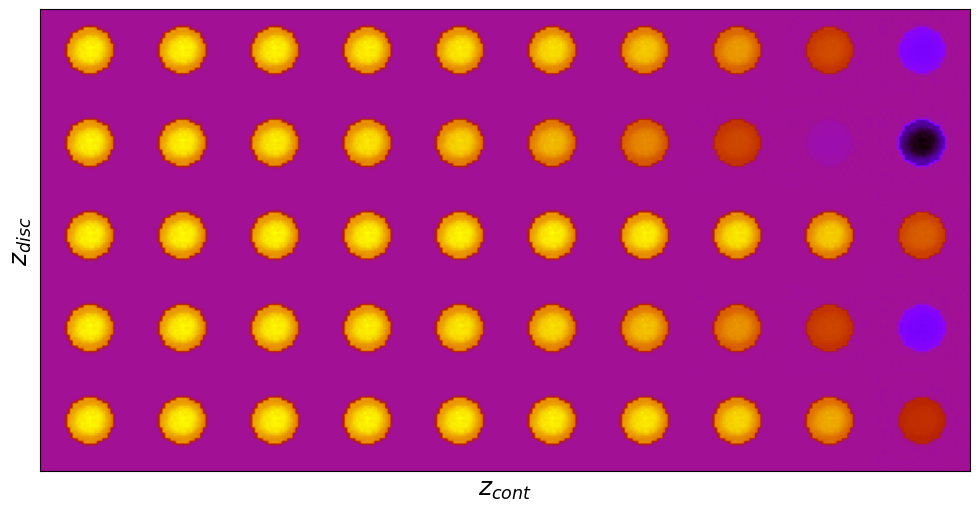

array([[0.39926422, 0.39926422, 0.39926422, ..., 0.39926422, 0.39926422,
        0.39926422],
       [0.39926422, 0.39926422, 0.39926422, ..., 0.39926422, 0.39926422,
        0.39926422],
       [0.39926422, 0.39926422, 0.39926457, ..., 0.3984663 , 0.39926422,
        0.39926422],
       ...,
       [0.39926422, 0.39926422, 0.3992666 , ..., 0.3995408 , 0.39926422,
        0.39926422],
       [0.39926422, 0.39926422, 0.39927378, ..., 0.3958409 , 0.39926422,
        0.39926422],
       [0.39926422, 0.39926422, 0.39926875, ..., 0.3970879 , 0.39926422,
        0.39926422]], dtype=float32)

In [28]:
jvae.manifold_traversal(0)

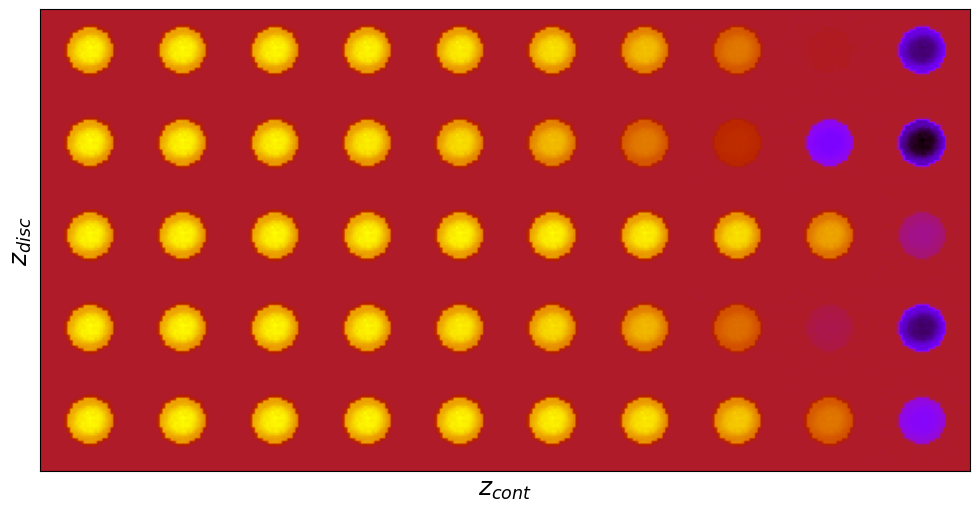

array([[0.47389695, 0.47389695, 0.47389695, ..., 0.47389695, 0.47389695,
        0.47389695],
       [0.47389695, 0.47389695, 0.47389695, ..., 0.47389695, 0.47389695,
        0.47389695],
       [0.47389695, 0.47389695, 0.47389823, ..., 0.47317186, 0.47389695,
        0.47389695],
       ...,
       [0.47389695, 0.47389695, 0.47389615, ..., 0.4752004 , 0.47389695,
        0.47389695],
       [0.47389695, 0.47389695, 0.47389776, ..., 0.47105733, 0.47389695,
        0.47389695],
       [0.47389695, 0.47389695, 0.47389695, ..., 0.47310144, 0.47389695,
        0.47389695]], dtype=float32)

In [29]:
jvae.manifold_traversal(1)

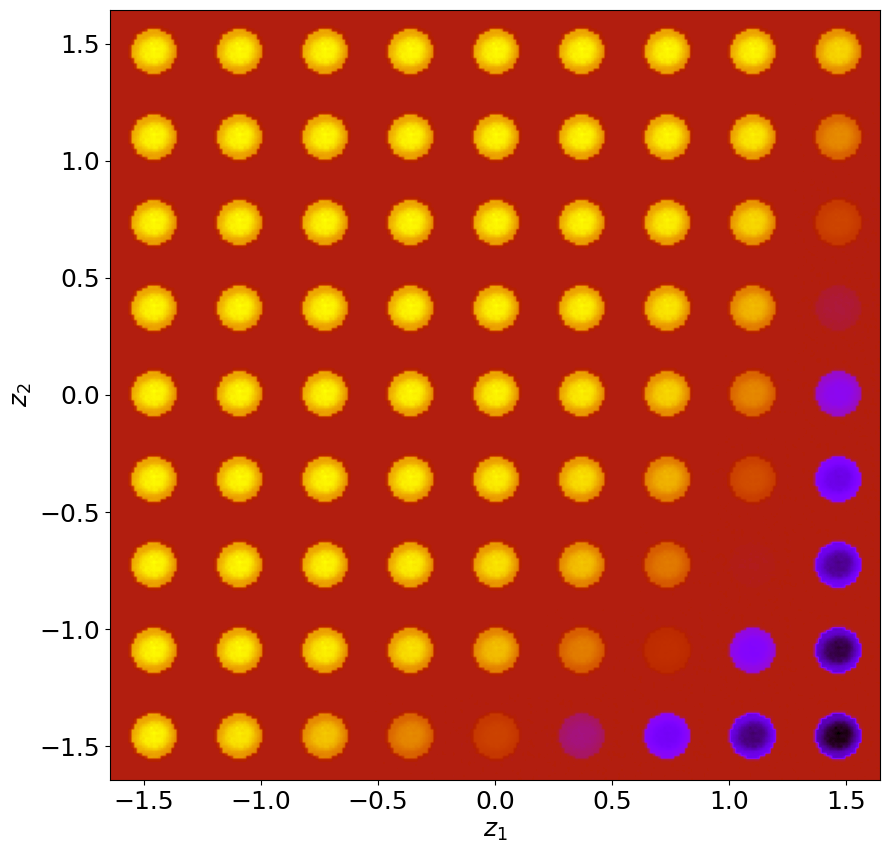

array([[0.49075869, 0.49072298, 0.49073481, ..., 0.49048406, 0.48970775,
        0.48950682],
       [0.49070766, 0.4907026 , 0.4907499 , ..., 0.49142196, 0.4918788 ,
        0.49106781],
       [0.49073623, 0.49072121, 0.49074712, ..., 0.49083816, 0.49087715,
        0.48891559],
       ...,
       [0.49072513, 0.4907286 , 0.49072568, ..., 0.49078846, 0.49073321,
        0.49121617],
       [0.49072602, 0.49072661, 0.4907271 , ..., 0.49091016, 0.49069796,
        0.49087024],
       [0.49072519, 0.4907253 , 0.49072644, ..., 0.4908266 , 0.49039918,
        0.49099297]])

In [54]:
jvae.manifold2d(cmap="gnuplot")

In [41]:
z_mean, z_sd, alphas = jvae.encode(images)

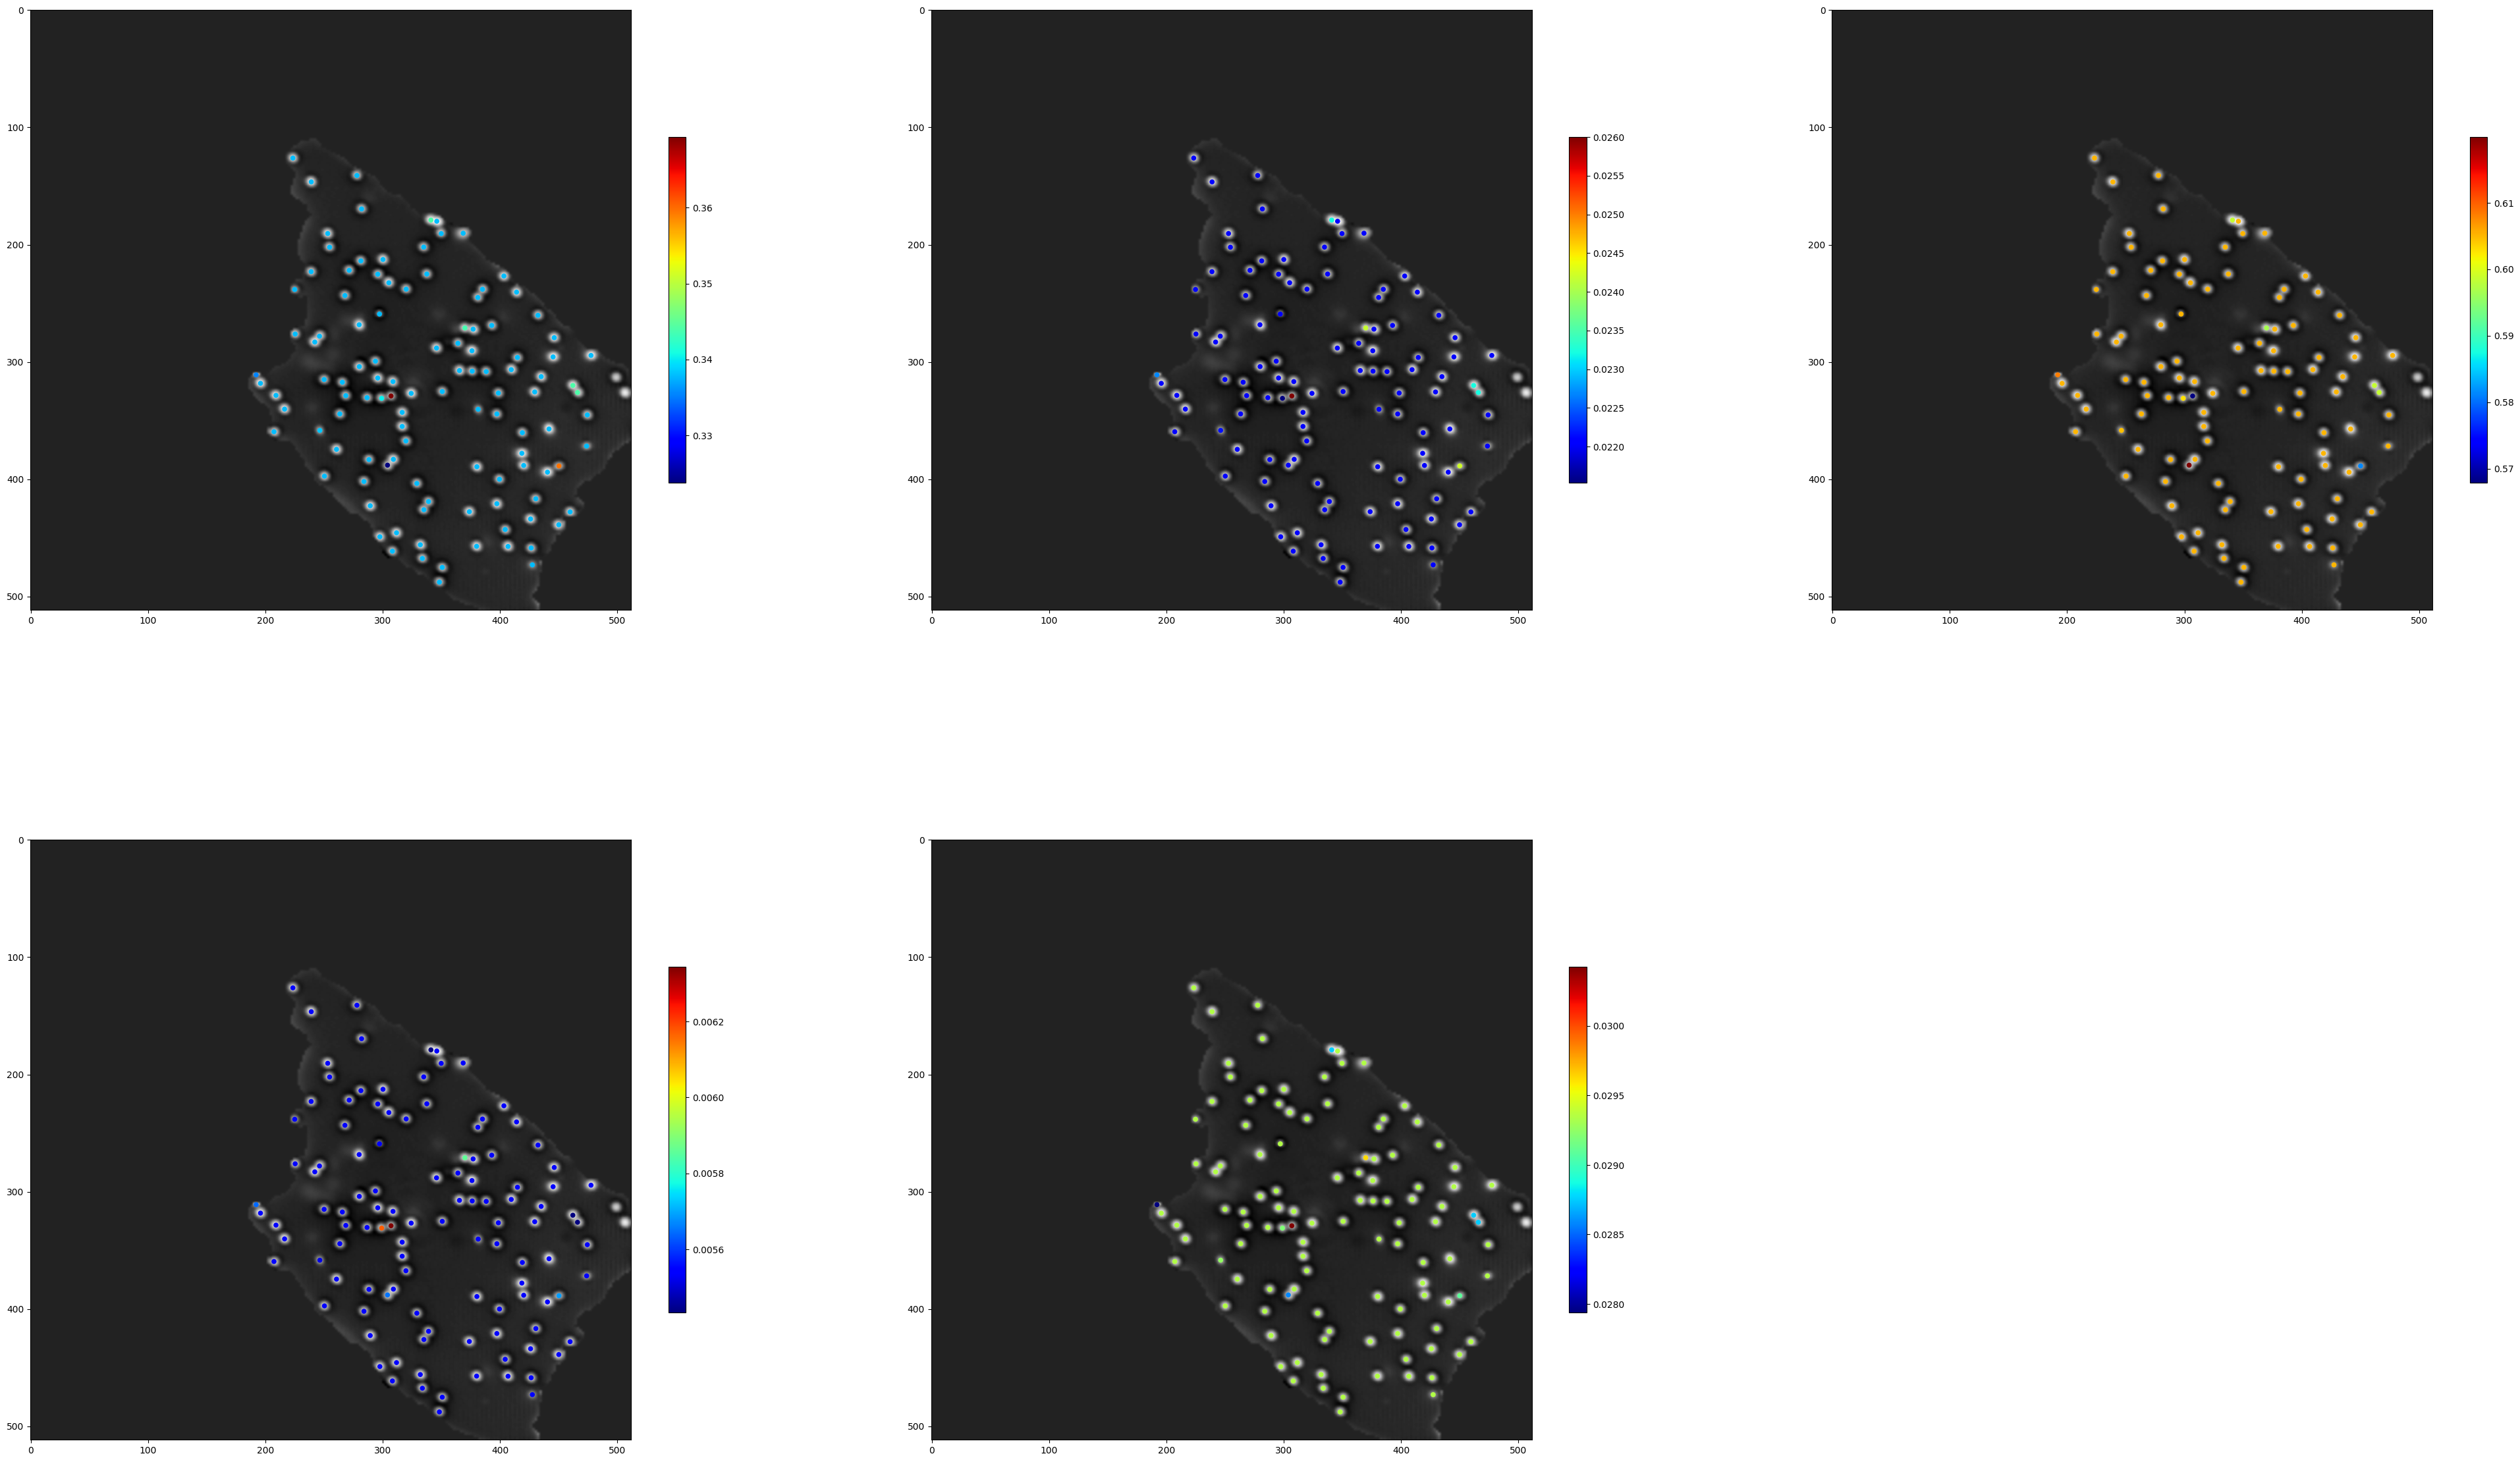

In [50]:
num_cols = (alphas.shape[1] + 1) // 2

fig, ax = plt.subplots(2, num_cols, figsize=(50, 30))

ax = ax.flatten()

for i in range(alphas.shape[1]):
    im = ax[i].imshow(expdata, cmap="gray")
    sc = ax[i].scatter(coordinates[:, 0], coordinates[:, 1], c=alphas[:, i], s=20,
                       cmap="jet")
    fig.colorbar(sc, ax=ax[i], shrink=0.5)

for j in range(alphas.shape[1], len(ax)):
    fig.delaxes(ax[j])

plt.show()

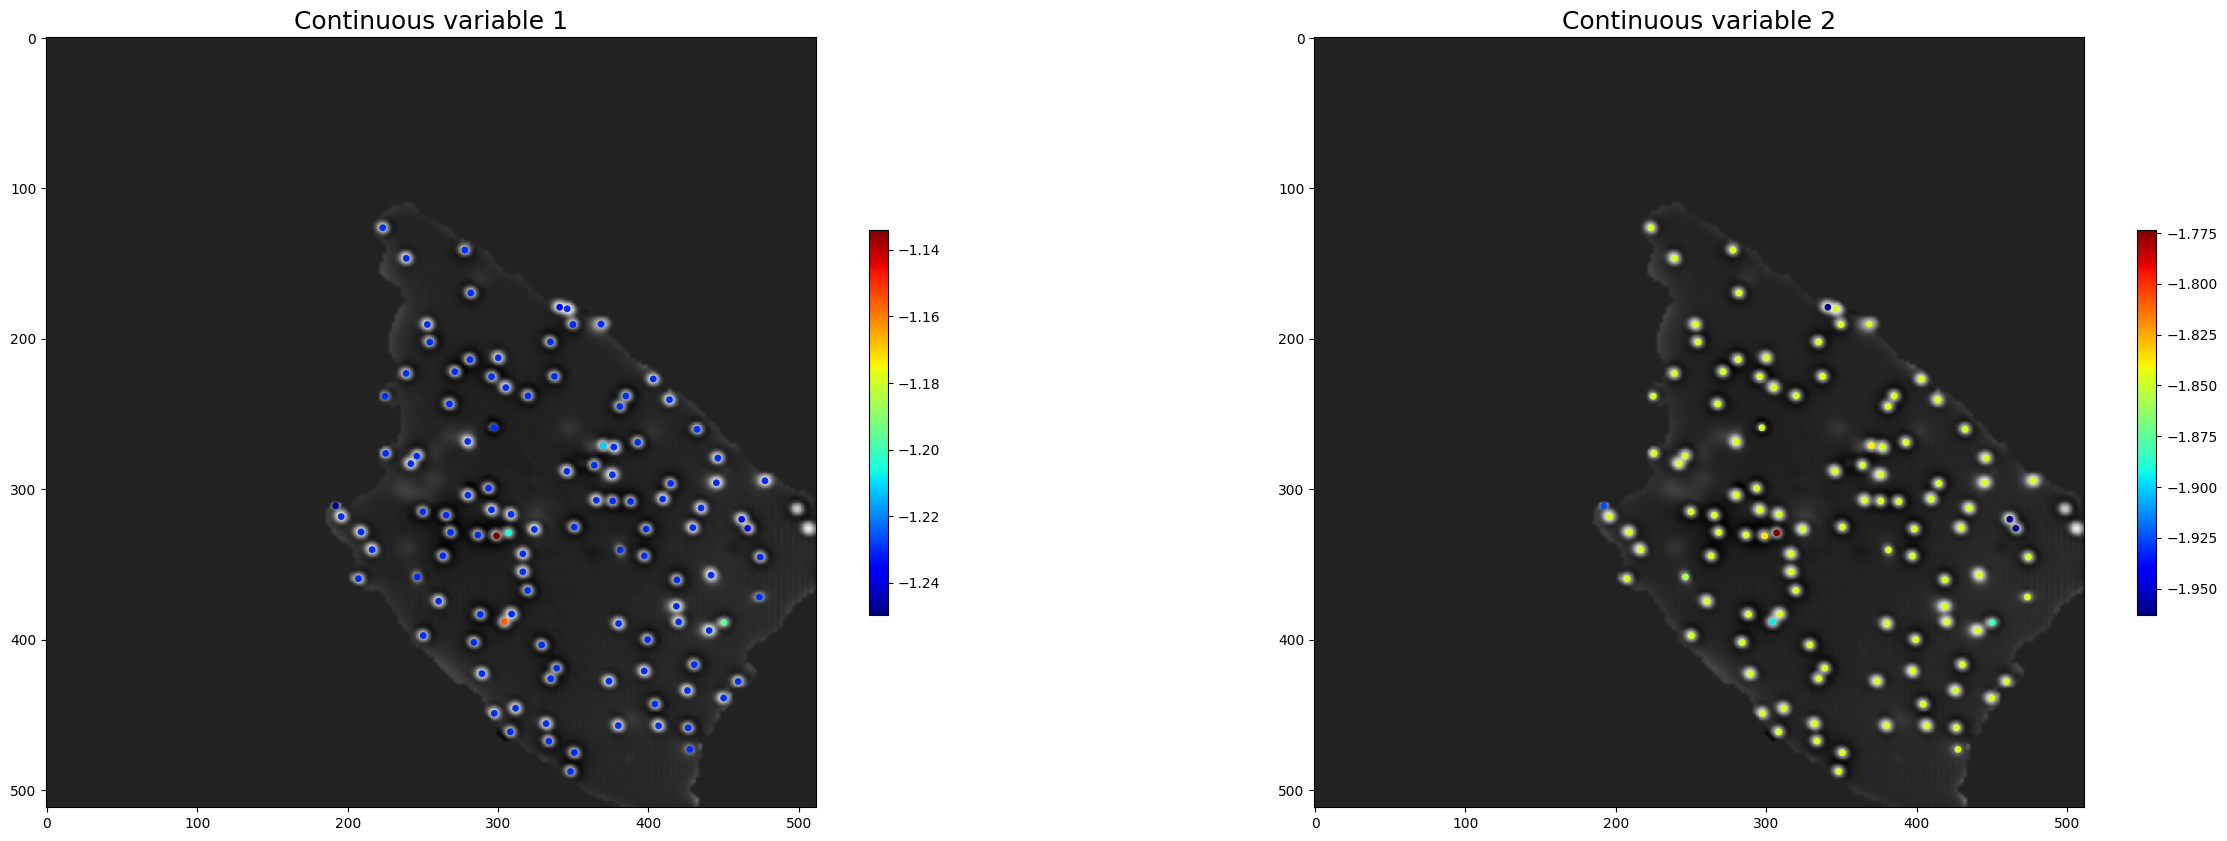

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
im0 = ax[0].imshow(expdata, cmap="gray")
sc0 = ax[0].scatter(coordinates[:, 0], coordinates[:, 1], c=z_mean[:,0], s=15,
            cmap="jet")
ax[0].set_title("Continuous variable 1", fontsize=18)
fig.colorbar(sc0, ax=ax[0], shrink=.5)

im1 = ax[1].imshow(expdata, cmap="gray")
sc1 = ax[1].scatter(coordinates[:, 0], coordinates[:, 1], c=z_mean[:,1], s=15,
            cmap="jet")
ax[1].set_title("Continuous variable 2", fontsize=18)
fig.colorbar(sc1, ax=ax[1], shrink=.5)


plt.show()

In [ ]:
\